Introduction to wavelet theory
=========

Author's Note:
---------------
I use this notebook to keep notes about my learning process about wavelet theory. I hope that these notes may help somebody else in their learning process, but as I am not an expert myself, they may of course contain erros. If you spot such an error, please let me know. 

What is a wavelet?
---------------
So... what exactly are these "wavelets" everybody is talking about? Well, just as a piglet is a small pig, a wavelet is - essentially - a small wave. A very simple example of such small wave is the mexican hat function:

$$m(x) = \frac{2}{\sqrt{3 \sigma} \pi^{\frac{1}{4}}} \left(1-\frac{x^2}{\sigma^2}\right) e^{\frac{-x^2}{2 \sigma^2}}$$

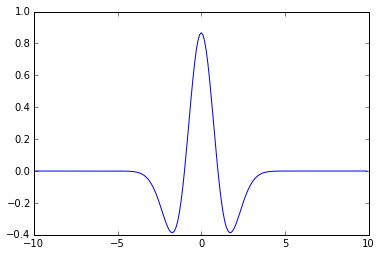

In [22]:
%matplotlib inline
# we will use numpy and matplotlib for all the following examples
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def mexican_hat(x, mu, sigma):
    return 2 / (np.sqrt(3 * sigma) * np.pi**0.25) * (1 - x**2 / sigma**2) * np.exp(-x**2 / (2 * sigma**2) )

xvals = np.arange(-10,10,0.1)
plt.plot(xvals, mexican_hat(xvals, 0, 1))
plt.show()

The mexican hat function/wavelet is the rescaled negative second derivative of the gaussian function (the probability distribution function of the normal distribution).

$$
g(x) = \frac{1}{\sigma \sqrt{2 \pi}} e^{\frac{- (x-mu)^2}{2 \sigma^2}}
$$

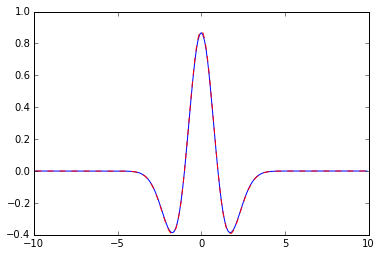

In [23]:
def gauss(x, mu, sigma):
    return 1.0 / (sigma * np.sqrt(2 * np.pi)) * np.exp(- (x - mu)**2 / (2 * sigma**2))

g = gauss(xvals, 0, 1)
m = mexican_hat(xvals, 0, 1)
dg = g[1:] - g[:-1] # linear approximation of first derivative
ddg = dg[1:] - dg[:-1] # linear approximation of second derivative

plt.plot(xvals, m, "b-")
fac = m[len(xvals)//2] / -ddg[len(xvals)//2] # scaling factor
plt.plot(xvals[1:-1], -ddg*fac, "r--")
plt.show()